In [1]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


doing some data preprocessing

In [2]:
prices_df = pd.read_csv("Data/GBCentralAllComplete_Prices.csv")
prices_df = prices_df.drop(columns=['Unnamed: 0', 'WeatherYear', 'Year'], errors='ignore') #getting rid of unneccesary columns
prices_df['Date'] = pd.to_datetime(prices_df['Date']) #making sure Date is correct format
prices_df = prices_df.set_index('Date')



In [3]:
prices_df

,DCDMLow,DCDMHigh,DRLow,DRHigh,DayAhead,Intraday,BM,Imbalance
Date,,,,,,,,
2024-01-01 00:00:00,3.370693,-0.344292,14.548610,-5.445916,0.008507,14.673760,0.619050,-28.06556
2024-01-01 00:30:00,3.370693,-0.344292,14.548610,-5.445916,0.008507,14.673760,12.033257,-28.06556
2024-01-01 01:00:00,3.370693,-0.344292,14.548610,-5.445916,0.008507,4.984709,-1.723718,-28.06556
2024-01-01 01:30:00,3.370693,-0.344292,14.548610,-5.445916,0.008507,-0.021203,-0.231200,-36.00933
2024-01-01 02:00:00,3.370693,-0.344292,14.548610,-5.445916,-8.490278,-3.662360,0.400883,-40.96746
...,...,...,...,...,...,...,...,...
2060-12-31 21:30:00,1.666407,0.075169,7.010102,-4.002441,30.006510,23.164980,28.561956,-16.99150
2060-12-31 22:00:00,1.666407,0.075169,7.010102,-4.002441,30.006510,24.329140,26.287658,20.41169
2060-12-31 22:30:00,1.666407,0.075169,7.010102,-4.002441,30.006510,18.084460,37.600984,-16.99150


In [4]:
prices_df = prices_df.head(96)
prices_df

,DCDMLow,DCDMHigh,DRLow,DRHigh,DayAhead,Intraday,BM,Imbalance
Date,,,,,,,,
2024-01-01 00:00:00,3.370693,-0.344292,14.54861,-5.445916,0.008507,14.673760,0.619050,-28.065560
2024-01-01 00:30:00,3.370693,-0.344292,14.54861,-5.445916,0.008507,14.673760,12.033257,-28.065560
2024-01-01 01:00:00,3.370693,-0.344292,14.54861,-5.445916,0.008507,4.984709,-1.723718,-28.065560
2024-01-01 01:30:00,3.370693,-0.344292,14.54861,-5.445916,0.008507,-0.021203,-0.231200,-36.009330
2024-01-01 02:00:00,3.370693,-0.344292,14.54861,-5.445916,-8.490278,-3.662360,0.400883,-40.967460
...,...,...,...,...,...,...,...,...
2024-01-02 21:30:00,3.885811,-0.344239,16.47950,-5.446521,60.864610,62.349780,35.145100,22.200070
2024-01-02 22:00:00,3.885811,-0.344239,16.47950,-5.446521,59.617960,63.960160,36.673040,20.781250
2024-01-02 22:30:00,3.885811,-0.344239,16.47950,-5.446521,59.617960,63.960160,46.107254,22.100430


Formulating the pulp problem (only for day ahead)

In [5]:
prices_df = prices_df.sort_index()
time_steps = prices_df.index
day_ahead_prices = prices_df['DayAhead'].to_dict()
intraday_prices = prices_df['Intraday'].to_dict()
bm_imbalance_prices = prices_df['Imbalance'].to_dict()

markets = ['DayAhead', 'Intraday', 'Imbalance']



#defining the parameters
T = len(prices_df)
dt = 0.5 # 30 minute intervals
battery_capacity = 20
p_max = 10
rte = 0.9 #round-trip efficiency 
soc_min = 0.1 * battery_capacity
soc_max = 0.9 * battery_capacity
soc_initial = 0.5 * battery_capacity

#defining the problem
prob = pulp.LpProblem("BESS_Optimisation", pulp.LpMaximize)

#defining the variables

charge_discharge_indices = [(t, m) for t in time_steps for m in markets] #creating a list of tuples for time steps and markets

charge = pulp.LpVariable.dicts("charge", charge_discharge_indices, lowBound=0, upBound=p_max, cat='Continuous') 
discharge = pulp.LpVariable.dicts("discharge", charge_discharge_indices, lowBound=0, upBound=p_max, cat='Continuous')
soc = pulp.LpVariable.dicts("soc", time_steps, lowBound=soc_min, upBound=soc_max, cat='Continuous')
is_charging = pulp.LpVariable.dicts("is_charging", time_steps, cat='Binary')
is_discharging = pulp.LpVariable.dicts("is_discharging", time_steps, cat='Binary')
big_M = p_max

#objective function: maximise profit

all_prices = {
    'DayAhead' : day_ahead_prices,
    'Intraday' : intraday_prices,
    'Imbalance' : bm_imbalance_prices
}

# maximise profit across all markets
prob += pulp.lpSum(
    (discharge[(t, m)] * all_prices[m][t] * dt) - (charge[(t, m)] * all_prices[m][t] * dt) 
    for t in time_steps 
    for m in markets
)

#constraints
for t in time_steps:
    
    # Define the total power for charging and discharging at time t
    Total_Charge_t = pulp.lpSum(charge[(t, m)] for m in markets)
    Total_Discharge_t = pulp.lpSum(discharge[(t, m)] for m in markets)

    # A. Total Power Limits (Linking Competition for Power)
    # The sum of power allocated to all markets cannot exceed P_MAX
    prob += Total_Charge_t <= p_max, f"Max_Total_Charge_Power_{t}"
    prob += Total_Discharge_t <= p_max, f"Max_Total_Discharge_Power_{t}"
    
    # B. Mutual Exclusivity (Linking to Binary Status)
    # The total power must be linked to the binary status (is_charging/is_discharging)
    prob += Total_Charge_t <= is_charging[t] * big_M, f"Charge_Exclusive_{t}"
    prob += Total_Discharge_t <= is_discharging[t] * big_M, f"Discharge_Exclusive_{t}"
    prob += is_charging[t] + is_discharging[t] <= 1, f"Charging Status_{t}"

    # C. Energy Balance (Linking Competition for Energy/SOC)
    # The SOC balance must use the total charge/discharge from all markets
    if t == time_steps[0]:
        prob += soc[t] == soc_initial + (Total_Charge_t * rte * dt) - (Total_Discharge_t / rte * dt), f"Energy_Balance_{t}"
    else:
        prev_t = time_steps[prices_df.index.get_loc(t) - 1]
        prob += soc[t] == soc[prev_t] + (Total_Charge_t * rte * dt) - (Total_Discharge_t / rte * dt), f"Energy_Balance_{t}"

prob.solve(pulp.PULP_CBC_CMD(msg=True, gapRel=0.3))

if pulp.LpStatus[prob.status] == 'Optimal':
    print("Solution Found, Extracting Results")
    results_df = pd.DataFrame(index=time_steps) 

    # ----------------------------------------------------------------------
    # FIX A: Extract Total Power by summing the market-indexed variables
    # ----------------------------------------------------------------------
    
    # 1. Total Charge/Discharge: Sums power across all markets for each time step (t)
    results_df['Total Charge'] = [
        sum(charge[(t, m)].varValue or 0 for m in markets)
        for t in time_steps
    ]

    results_df['Total Discharge'] = [
        sum(discharge[(t, m)].varValue or 0 for m in markets)
        for t in time_steps
    ]

    # SOC variable is correctly indexed only by time (t)
    results_df['SOC'] = [soc[t].varValue or 0 for t in time_steps]
    
    # ----------------------------------------------------------------------
    # FIX B: Extract Profit/Cost per Market and Total Profit
    # ----------------------------------------------------------------------

    total_profit_values = []
    
    for m in markets:
        # Extract the power allocated to *this* specific market
        results_df[f'Charge_{m}'] = [charge[(t, m)].varValue for t in time_steps]
        results_df[f'Discharge_{m}'] = [discharge[(t, m)].varValue for t in time_steps]
        
        # Calculate the profit contribution from *this* specific market
        market_profit = [
            (discharge[(t, m)].varValue * all_prices[m][t] * dt) - 
            (charge[(t, m)].varValue * all_prices[m][t] * dt)
            for t in time_steps
        ]
        results_df[f'Profit_{m}'] = market_profit
        
        # Add this market's profit to the running total list
        if not total_profit_values:
            total_profit_values = market_profit
        else:
            # Sum the new market profit with the existing total (element-wise)
            total_profit_values = [sum(x) for x in zip(total_profit_values, market_profit)]


    results_df['Total Hourly Profit'] = total_profit_values
    
    print(f"Total Co-optimized Objective Value (Sum of All Profits): {pulp.value(prob.objective)}")
    print("Results extracted successfully and detailed by market!")

else:
    print(f"No optimal solution found. Status: {pulp.LpStatus[prob.status]}")
    


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rajvirthind/University Work/MastersFinalProject/.venv/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/16/z78kgyr52517f7j445ngztrh0000gn/T/e6b21263bb634d6da414a9dfb2b3cafd-pulp.mps -max -ratio 0.3 -timeMode elapsed -branch -printingOptions all -solution /var/folders/16/z78kgyr52517f7j445ngztrh0000gn/T/e6b21263bb634d6da414a9dfb2b3cafd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 581 COLUMNS
At line 3845 RHS
At line 4422 BOUNDS
At line 5383 ENDATA
Problem MODEL has 576 rows, 864 columns and 2303 elements
Coin0008I MODEL read with 0 errors
ratioGap was changed from 0 to 0.3
Option for timeMode changed from cpu to elapsed
Continuous objective value is 18486.1 - 0.00 seconds
Cgl0004I processed model has 383 rows, 478 columns (192 integer (192 of which binary)) and 956 elements
Cbc0038I Initial state - 80 integers unsatisfied s

In [6]:
results_df

,Total Charge,Total Discharge,SOC,Charge_DayAhead,Discharge_DayAhead,Profit_DayAhead,Charge_Intraday,Discharge_Intraday,Profit_Intraday,Charge_Imbalance,Discharge_Imbalance,Profit_Imbalance,Total Hourly Profit
Date,,,,,,,,,,,,,
2024-01-01 00:00:00,0.000000,10.0,4.444444,0.0,0.0,0.00000,0.0,10.0,73.368800,0.000000,0.0,0.000000,73.368800
2024-01-01 00:30:00,10.000000,0.0,8.944444,0.0,0.0,0.00000,0.0,0.0,0.000000,10.000000,0.0,140.327800,140.327800
2024-01-01 01:00:00,0.000000,10.0,3.388889,0.0,0.0,0.00000,0.0,10.0,24.923545,0.000000,0.0,0.000000,24.923545
2024-01-01 01:30:00,10.000000,0.0,7.888889,0.0,0.0,0.00000,0.0,0.0,0.000000,10.000000,0.0,180.046650,180.046650
2024-01-01 02:00:00,0.000000,6.8,4.111111,0.0,0.0,0.00000,0.0,6.8,-12.452024,0.000000,0.0,0.000000,-12.452024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-02 21:30:00,4.691358,0.0,4.111111,0.0,0.0,0.00000,0.0,0.0,0.000000,4.691358,0.0,-52.074238,-52.074238
2024-01-02 22:00:00,10.000000,0.0,8.611111,0.0,0.0,0.00000,0.0,0.0,0.000000,10.000000,0.0,-103.906250,-103.906250
2024-01-02 22:30:00,0.000000,10.0,3.055556,0.0,0.0,0.00000,0.0,10.0,319.800800,0.000000,0.0,0.000000,319.800800


<Axes: xlabel='Date'>

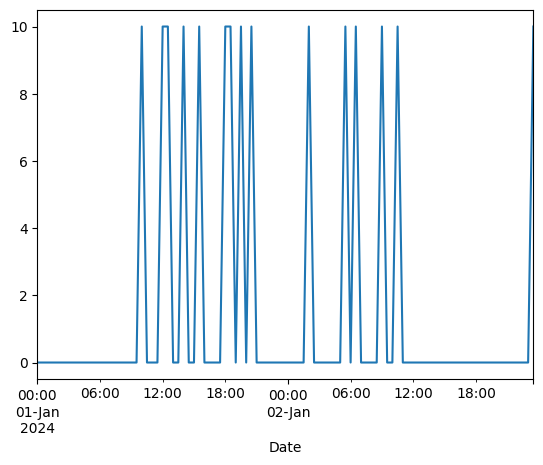

In [7]:
results_df.Discharge_DayAhead.plot()


<Axes: xlabel='Date'>

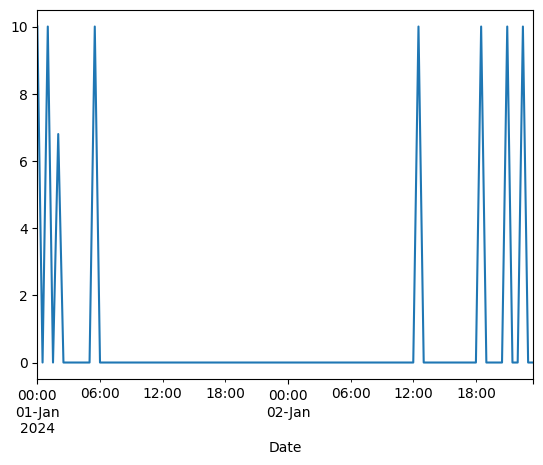

In [11]:
results_df.Discharge_Intraday.plot()

<Axes: xlabel='Date'>

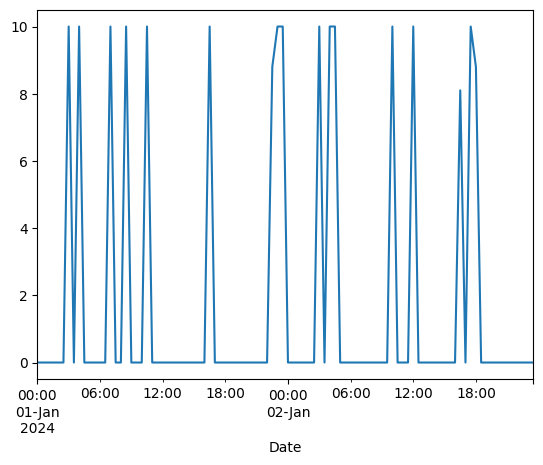

In [12]:
results_df.Discharge_Imbalance.plot()

<Axes: xlabel='Date'>

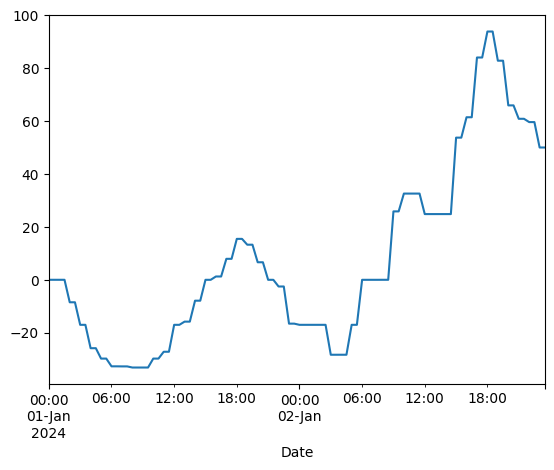

In [8]:
prices_df.DayAhead.plot()

<Axes: xlabel='Date'>

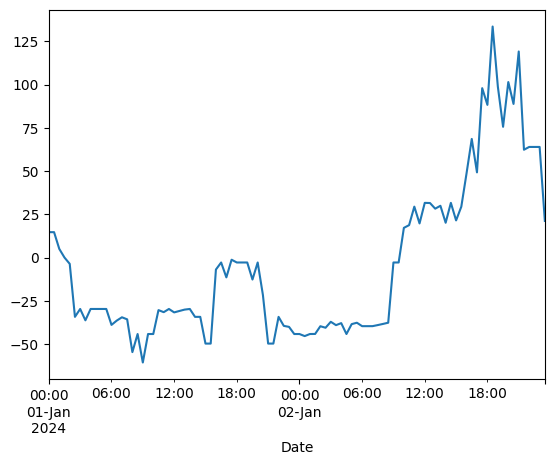

In [9]:
prices_df.Intraday.plot()

<Axes: xlabel='Date'>

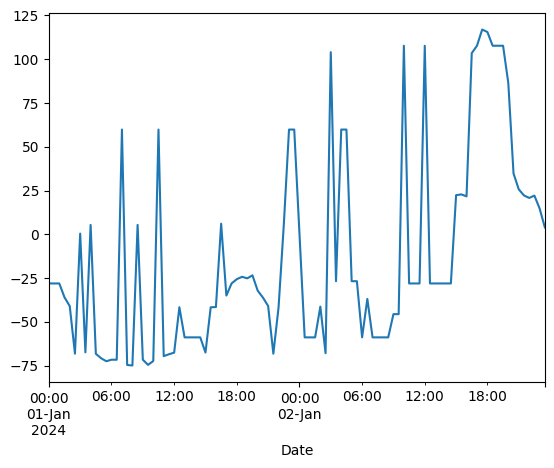

In [10]:
prices_df.Imbalance.plot()